In [78]:
# !pip install gensim pymorphy2 seaborn pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.1 MB/s eta 0:00:00
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=635d7bac9b3e3d148d968812df97ea9289c78e55ddab047b4e5ddcc6c20fa0ba
  Stored in directory: /Users/mnefedov/Library/Caches/pip/wheels/1f/ef/46/1dc1c1e5d8ff2f3b44cccaf004cf64488cf82b5c359fbc8efb
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=5a37f3b27142efedcf3e277cb51d972ba444a2ec76aff98fef3348d1174ec2b8
  Stored in directory: /Users/mnefedov/Library/Caches/pip/wheels/96/66/19/2de75120f5d0bc185e9d16cf0fd223d8471ed025de08e45867
Successf

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import gensim
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()



На одном из прошлых занятий мы научились представлять тексты в виде векторов методом мешка слов. Мы векторизовали тексты с помощью CountVectorizer/TfidfVectorizer, которые выдают большие разреженные вектора. Для них даже есть специальная структура данных, которая позволяет хранить такие вектора в памяти. Не все алгоритмы даже в sklearn умеют работать с этой структурой данных. Привести ее к обычному np.array можно, но в большинстве случаев такая матрица просто не поместится в память компьютера. Чтобы обойти это ограничение можно воспользоваться методами снижения размерности, в частности матричными разложениями. 


Помимо решения технической проблемы, снижение размерности "синонимизирует" слова в изначальной матрице. Это позволяет нам считать близость между текстами, у которых нет пересечений по словам, а также извлекать из полученных векторов темы.

Давайте посмотрим как это работает.

# Матричные разложения 

Матричные разложения - это представление матрицы в виде произведения нескольких других матриц. Есть достаточно много алгоритмов для разложения матриц и у каждого из них свои свойства и области применения. В семинаре мы посмотрим на два разложения SVD и NMF. Нам не очень интересно в рамках NLP, как они устроены с математической точки зрения. Важнее понять, какие у них свойства и как их можно применять.  

### SVD

SVD (Singular value decomposition) или сингулярное разложение - это представление матрицы в виде произведения трех специальных матриц (о том, что в них специального можно почитать [тут](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5), для семинара это не важно)

SVD один из центральных алгоритмов в линейной алгебре. Схематически можно изобразить его вот так.

In [10]:
Image(url="https://miro.medium.com/max/1362/1*AQ3ohYYQtJLIGWOc5UBrDQ.webp", retina=True,
     width=1000, height=900)

У SVD есть также приблезительная реализация - TruncatedSVD. В SVD в средней диагональной матрице значения отсортированы по значимости и можно взять только ток-K самых значимых компонент. Тогда разложение будет выглядеть как-то так (обратите внимание на размерности)

In [13]:
Image(url="https://miro.medium.com/max/1364/1*6VvLOCJZZZsa0-l9x4mT5Q.webp",
     width=1000, height=900)


K как правило сильно ниже размера словаря и поэтому используя матрицу U вместо оригинальной мы сильно уменьшаем размерность.

### NMF

NMF (Non-negative matrix factorization) или неотрицательное матричное разложение - это представление матрицы в виде произведения двух матриц, значения в которых больше или равны 0. 

In [14]:
Image(url="https://www.researchgate.net/publication/312157184/figure/fig1/AS:448453387001860@1483931027472/Conceptual-illustration-of-non-negative-matrix-factorization-NMF-decomposition-of-a.png",
     width=1000, height=900)

В NMF параметр K нужно задать заранее, под него будут подбираться две матрицы. Как правило, чем выше K, тем лучше будет приблежаться изначальная матрица. Но при этом будет увеличиваться потребление памяти и время схождения.

Давайте попробуем понизить размерности с помощью этих алгоритмов. 

В этот раз используем данные объявлений на Авито. По описанию нужно предсказать категорию товара. Данные взяты из этого соревнования - https://www.kaggle.com/c/avito-demand-prediction (в семинаре использована лишь небольшой процент всех данных соревнования)

In [15]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)



In [16]:
data = pd.read_csv('avito_category_classification.csv')

In [17]:
data

category_name  \
0                     Автомобили   
1         Детская одежда и обувь   
2              Предложение услуг   
3                     Автомобили   
4                Бытовая техника   
...                          ...   
9893  Товары для детей и игрушки   
9894      Детская одежда и обувь   
9895   Одежда, обувь, аксессуары   
9896      Детская одежда и обувь   
9897             Бытовая техника   

                                            description  
0               отличное состояние,обслужиание в салоне  
1     В отличном состоянии. Фирма KIKO. Очень теплый...  
2     Изготовление ограждений, перил,качелей, турник...  
3     Автомобиль в отличном техническом состоянии. О...  
4     Продается газовая плита "Гефест" (Белоруссия) ...  
...                                                 ...  
9893  Чтобы посмотреть весь ассортимент нашего магаз...  
9894  Весна,осень.74-80.вопросы можно в вайбер,двухс...  
9895  Кимоно Green Hill. Состояние  отличное,  рост ...  
9896  Б/у кроссовки на девочку. Носили только в спор...  
9897                            Холодильник на гарантии  

[9898 rows x 2 columns]

In [18]:
data['description_norm'] = data['description'].apply(normalize)

Интерфейс у алгоритмов разложения в sklearn такой же как и у векторайзеров, только применять их нужно уже к векторизованным текстам.

In [19]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500) # 500 это параметр K

In [20]:
X_sparse = cv.fit_transform(data['description_norm'])
X = svd.fit_transform(X_sparse)

Давайте посмотрим на получившиеся размерности

In [21]:
X_sparse.shape # после векторизации

(9898, 4468)

In [22]:
X.shape # после разложения

(9898, 500)

Можно посмотреть насколько сильно мы потеряли в информации (чем ближе это число к 1, тем лучше )

In [42]:
sum(svd.explained_variance_ratio_)

0.7900862005261179

## Использование в классификаторах

Теперь попробуем сравнить качество классификации до и после svd

Для удобства будем использовать Pipeline из sklearn. В нем можно задать последовательность операций с данными и дальше использовать пайплайн как единую модель. Это сэкономит нам несколько строчек на последовательных fit/tranform/fit/predict.

In [43]:
pipeline_bow = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_svd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

#### Кросс-валидация

Также для более точных результатов оцениваться будем на кросс-валидации. 

В кросс-валидации мы разбиваем модель на трейн и тест не 1 раз, а - несколько, при этом нужно, чтобы каждый элемент выборки побывал хотя бы однажды и в обучающей и в тестовой выборке. На каждом разбиении модель обучается с нуля, а метрики отдельных моделей усредняются, чтобы получить 1 общую оценку. Это позволяет сгладить влияние случайных факторов на итоговые метрики.

Существует множество стратегий кросс-валидации и основное отличие в них в том, как мы разбиваем выборку на обучающие и тестовые множества. Давайте разберем несколько стратегий:

1) **Leave-one-out** - на каждом разбиении мы выбираем 1 элемент из выборки и считаем его тестовым множеством, а на всем остальном обучаемся. Для этой стратегии нам нужно построить N моделей, где N равно количеству примеров в изначальной выборке. Такая стратегия позволяет наиболее достоверно понять качество модели, которая получится если обучится на всех доступных данных, но на практике оцениваться так очень долго. Эту стратегию можно увидеть только, когда данных очень мало.  

2) **Leave-K-out** - на каждом разбиении мы выбираем K элементов и считаем их тестовым множеством, а на всем остальном обучаемся. Параметр K нужно задавать самостоятельно в зависимости от количества данных. Это уже более реалистичная стратегия, но настраивать параметр K не очень удобно - он будет зависеть от количества примеров в изначальной выборке.

3) **K-Fold** - вместо указания размера тестовой выборки на каждом из разбиений мы можем указать количество разбиений, которое хотим получить в итоге (размер посчитается автоматически). Это наиболее популярная стратегия. Параметр K в K-Fold будет равен количеству моделей, которое будет построено. На итоговую оценку больше всего будет влияеть именно количество моделей, а не различия в размерах тестовой выборки, поэтому удобно настраивать кросс-валидацию именно через количество разбиений. Однако не стоит ставить K слишком маленьким (меньше 5), потому что с уменьшением K будет уменьшаться обучающая выборка на каждом шаге (на 2 сплитах все будет разбиваться 50% на 50%)

4) **Stratified K-Fold** - то же, что и K-Fold, но при разбиении мы также сохраняем баланс классов в обучающей и тестовой выборке (так чтобы он соответствовал балансу в изначальной выборке). Это бывает важно, когда есть сильный дисбаланс в распределении классов и случайное разбиение может привести к ситуации, когда в тестовой выборке полностью отсутствует какой-то класс.

Схематичное представление кросс-валидации:
    

In [44]:
Image(url="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/07/15185337/blogs-15-7-2020-01-1024x565.jpg",
     width=500, height=500)

До этого мы использовали classification_report, но его не удобно использовать при кросс-валидации. Давайте напишем свой classification_report с встроенной кросс-валидацией.

In [45]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

In [27]:
metrics_bow, errors_bow = eval_table(data['description_norm'], data['category_name'], pipeline_bow)
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd)

In [28]:
metrics_bow

precision  precision_std  recall  recall_std  \
Ремонт и строительство           0.83           0.41    0.02        0.01   
Детская одежда и обувь           0.65           0.04    0.54        0.05   
Квартиры                         0.95           0.03    0.85        0.03   
Одежда, обувь, аксессуары        0.35           0.01    0.92        0.03   
Телефоны                         0.99           0.03    0.26        0.04   
Мебель и интерьер                0.67           0.52    0.01        0.01   
Автомобили                       0.99           0.02    0.50        0.06   
Предложение услуг                0.93           0.12    0.04        0.02   
Товары для детей и игрушки       1.00           0.00    0.15        0.03   
Бытовая техника                  0.00           0.00    0.00        0.00   
mean                             0.74           0.12    0.33        0.03   

                              f1  f1_std  
Ремонт и строительство      0.04    0.02  
Детская одежда и обувь      0.59    0.02  
Квартиры                    0.90    0.02  
Одежда, обувь, аксессуары   0.50    0.01  
Телефоны                    0.41    0.05  
Мебель и интерьер           0.03    0.02  
Автомобили                  0.66    0.05  
Предложение услуг           0.08    0.03  
Товары для детей и игрушки  0.26    0.04  
Бытовая техника             0.00    0.00  
mean                        0.35    0.03

In [29]:
metrics_svd

precision  precision_std  recall  recall_std  \
Ремонт и строительство           0.71           0.15    0.11        0.03   
Детская одежда и обувь           0.45           0.02    0.68        0.02   
Квартиры                         0.91           0.02    0.89        0.03   
Одежда, обувь, аксессуары        0.46           0.01    0.76        0.02   
Телефоны                         0.94           0.04    0.36        0.07   
Мебель и интерьер                0.85           0.17    0.03        0.01   
Автомобили                       0.87           0.04    0.59        0.05   
Предложение услуг                0.76           0.08    0.52        0.07   
Товары для детей и игрушки       0.84           0.05    0.17        0.02   
Бытовая техника                  0.90           0.11    0.07        0.03   
mean                             0.77           0.07    0.42        0.04   

                              f1  f1_std  
Ремонт и строительство      0.18    0.05  
Детская одежда и обувь      0.54    0.02  
Квартиры                    0.90    0.02  
Одежда, обувь, аксессуары   0.58    0.01  
Телефоны                    0.51    0.08  
Мебель и интерьер           0.06    0.02  
Автомобили                  0.70    0.04  
Предложение услуг           0.62    0.06  
Товары для детей и игрушки  0.28    0.03  
Бытовая техника             0.13    0.05  
mean                        0.45    0.04

Чтобы не испортить себе глаза можем вычесть одно и другого и сразу понять, что и как отличается

In [30]:
metrics_svd - metrics_bow 

precision  precision_std  recall  recall_std  \
Ремонт и строительство          -0.12          -0.26    0.09        0.02   
Детская одежда и обувь          -0.20          -0.02    0.14       -0.03   
Квартиры                        -0.04          -0.01    0.04        0.00   
Одежда, обувь, аксессуары        0.11           0.00   -0.16       -0.01   
Телефоны                        -0.05           0.01    0.10        0.03   
Мебель и интерьер                0.18          -0.35    0.02        0.00   
Автомобили                      -0.12           0.02    0.09       -0.01   
Предложение услуг               -0.17          -0.04    0.48        0.05   
Товары для детей и игрушки      -0.16           0.05    0.02       -0.01   
Бытовая техника                  0.90           0.11    0.07        0.03   
mean                             0.03          -0.05    0.09        0.01   

                              f1  f1_std  
Ремонт и строительство      0.14    0.03  
Детская одежда и обувь     -0.05    0.00  
Квартиры                    0.00    0.00  
Одежда, обувь, аксессуары   0.08    0.00  
Телефоны                    0.10    0.03  
Мебель и интерьер           0.03    0.00  
Автомобили                  0.04   -0.01  
Предложение услуг           0.54    0.03  
Товары для детей и игрушки  0.02   -0.01  
Бытовая техника             0.13    0.05  
mean                        0.10    0.01

Качество немного улучшилось, но это не значит, что разложение всегда улучшает качество. Все зависит от задачи и от алгоритма машинного обучения. Поэтому в реальной задаче лучше пробовать и то и другое.

Посмотрим на ошибки, которые делают полученные модели (в идеальном случае закрасится только диагональ)

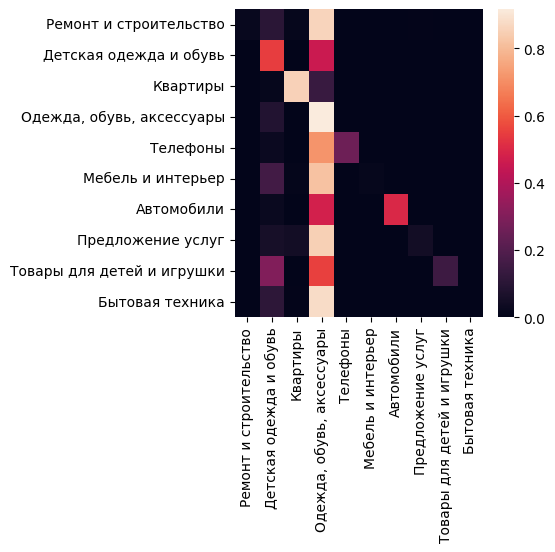

In [31]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_bow, xticklabels=metrics_bow.index.tolist()[:-1], 
            yticklabels=metrics_bow.index.tolist()[:-1])
plt.show()

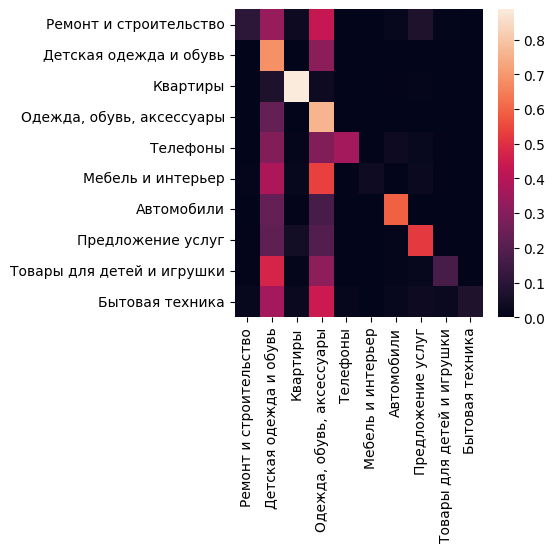

In [32]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

Давайте попробуем NMF (он работает дольше)

In [33]:

pipeline_nmf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])


In [34]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf)

In [35]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Ремонт и строительство           0.63           0.24    0.05        0.03   
Детская одежда и обувь           0.65           0.03    0.69        0.03   
Квартиры                         0.90           0.04    0.95        0.01   
Одежда, обувь, аксессуары        0.43           0.02    0.83        0.02   
Телефоны                         0.96           0.04    0.28        0.12   
Мебель и интерьер                0.80           0.15    0.14        0.08   
Автомобили                       0.86           0.04    0.79        0.05   
Предложение услуг                0.68           0.05    0.49        0.10   
Товары для детей и игрушки       0.85           0.04    0.35        0.05   
Бытовая техника                  0.33           0.52    0.01        0.01   
mean                             0.71           0.12    0.46        0.05   

                              f1  f1_std  
Ремонт и строительство      0.09    0.06  
Детская одежда и обувь      0.67    0.02  
Квартиры                    0.92    0.02  
Одежда, обувь, аксессуары   0.57    0.02  
Телефоны                    0.42    0.17  
Мебель и интерьер           0.23    0.11  
Автомобили                  0.82    0.03  
Предложение услуг           0.56    0.08  
Товары для детей и игрушки  0.50    0.05  
Бытовая техника             0.01    0.02  
mean                        0.48    0.06

In [36]:
metrics_nmf - metrics_bow

precision  precision_std  recall  recall_std  \
Ремонт и строительство          -0.20          -0.17    0.03        0.02   
Детская одежда и обувь           0.00          -0.01    0.15       -0.02   
Квартиры                        -0.05           0.01    0.10       -0.02   
Одежда, обувь, аксессуары        0.08           0.01   -0.09       -0.01   
Телефоны                        -0.03           0.01    0.02        0.08   
Мебель и интерьер                0.13          -0.37    0.13        0.07   
Автомобили                      -0.13           0.02    0.29       -0.01   
Предложение услуг               -0.25          -0.07    0.45        0.08   
Товары для детей и игрушки      -0.15           0.04    0.20        0.02   
Бытовая техника                  0.33           0.52    0.01        0.01   
mean                            -0.03           0.00    0.13        0.02   

                              f1  f1_std  
Ремонт и строительство      0.05    0.04  
Детская одежда и обувь      0.08    0.00  
Квартиры                    0.02    0.00  
Одежда, обувь, аксессуары   0.07    0.01  
Телефоны                    0.01    0.12  
Мебель и интерьер           0.20    0.09  
Автомобили                  0.16   -0.02  
Предложение услуг           0.48    0.05  
Товары для детей и игрушки  0.24    0.01  
Бытовая техника             0.01    0.02  
mean                        0.13    0.03

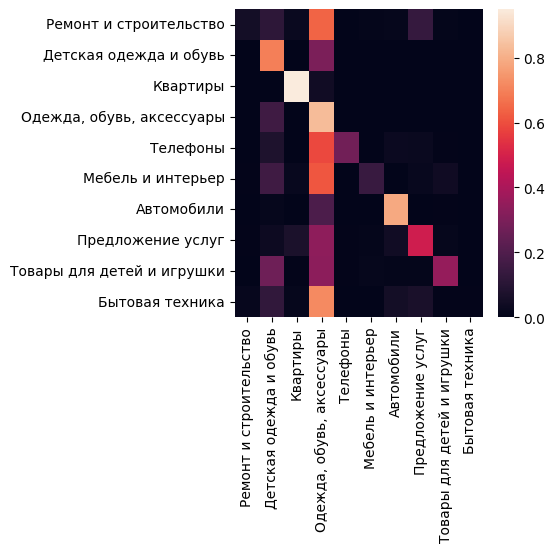

In [37]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

Понижение размерности не единственное для чего может пригодиться разложение матриц. 
Каждая из K размерностей в получившихся векторах соответствует группе семантически близких слов! То есть представление текста можно интерпретировать как тематическую характеристуку текста (и у каждой темы есть коэффициент). Эти темы подбираются под корпус и могут быть не очень интерпретируемы, но уже сам факт этого можно использовать. 

По векторам пропущенным через разложение лучше получается искать близкие тексты - так как косинусное расстояние в этом случае учитывает не только пересечение по словам, но и по темам. То есть можно найти похожий текст даже если в нем нет ни одного такого же слова, но есть синонимы.

Сравним поиск похожих текстов:

In [47]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500)
X_sparse = cv.fit_transform(data['description_norm'])
X = svd.fit_transform(X_sparse)

Текст

In [48]:
data.loc[3, 'description']

'Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.'

Поиск после SVD

In [49]:
top_idx = cosine_distances(X[3].reshape(1, -1), X).argsort()[0,:5]
data.loc[top_idx, 'description'].values.tolist()

['Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.',
 'Автомобиль в отличном состоянии. Год выпуска 2012. Куплен в феврале 2013 года в салоне официального дилера. ПТС оригинал. Сервисная книжка с отметками о прохождении ТО. Полный комплект документов и ключей. Комплект зимней резины и ковриков. Комплектация на фото. В ДТП не участвовал.',
 'АВТОМОБИЛЬ ПО ОРИГИНАЛУ ПТС 2014г. ОДИН ВЛАДЕЛЕЦ! ОБСЛУЖАННЫЙ ПО РЕГЛАМЕНТУ! ПО ДВС, ТРАНСМИССИИ, ПОДВЕСКЕ НАРЕКАНИЙ НЕТ. ЧИСТЫЙ УХОЖЕННЫЙ САЛОН, КУЗОВ В ИДЕАЛЬНОМ СОСТОЯНИИ. ДВА КОМПЛЕКТА РЕЗИНЫ./\n/\nТОРГ ПРИ ОСМОТРЕ!/\nВОЗМОЖНО В КРЕДИТ!/\nДИАГНОСТИКА ПРИВЕТСТВУЕТСЯ!/\nЛЮБЫЕ ВАРИАНТЫ ОБМЕНА!',
 'Hyundai Accent 2007 г.в /\n- Один хозяин! ПТС оригинал /\n- Климат (кондиционер)/\n- Сигнализация/\n- Зеркала с обогревом/\n- Мультимедиа (CD)/\n- Усилитель руля (гидро)/\n- Автомобиль в очень хорошем состоянии!/\n- 

Поиск до SVD

In [50]:
top_idx = cosine_distances(X_sparse[3].reshape(1, -1), X_sparse).argsort()[0,:5]
data.loc[top_idx, 'description'].values.tolist()

['Автомобиль в отличном техническом состоянии. Одна хозяйка, оригинальная ПТС. Полный комплект ключей. ТО проходила вовремя. Салон чистый, не прокуренный. Музыка Пионер. Защита картера. Торг.',
 'Состояние нового с полным комплектом',
 'В отличном состоянии. Полный комплект.',
 'Состояние отличное,  полный комплект',
 'Автомобиль в отличном состоянии. Год выпуска 2012. Куплен в феврале 2013 года в салоне официального дилера. ПТС оригинал. Сервисная книжка с отметками о прохождении ТО. Полный комплект документов и ключей. Комплект зимней резины и ковриков. Комплектация на фото. В ДТП не участвовал.']

Часто хочется проанализировать полученные темы более детально и даже дать им названия. На основе таких тем можно сделать полезную продуктовую функцию (например, твиттер советует твиты по темам); категоризовать большую коллекцию документов для личного использования (например, разложить кучу научных статей по темам и читать только интересующую тему); или собрать или расширить тематические словари. 

Такой подробный анализ тем - отдельная большая задача, которая называется тематическим моделированием. Ее можно решать матричными разложениями, но в основном для этого используются специальные алгоритмы, самый популярный из которых - LDA.

# Тематическое моделирование

Для начала попробуем использовать матричные разложения, а потом сравним результат с LDA. 

И SVD и NMF помимо матрицы документы на темы строят матрицу слова на темы, которую можно проанализировать и понять, из каких слов состоят темы. Однако SVD использовать не удобно, т.к. значения в итоговых матрицах могут быть любыми (положительными, отрицательными, нулем, больше 1 по модулю) и не очень понятно, как использовать их в качестве принадлежности к определеной теме.

А вот NMF подходит отлично - значения в итоговых матрицах либо нулевые либо положительные. Можно интерпретировать это так - чем больше число, тем больше слово связано с темой. 

Возьмем более разнообразный корпус

In [51]:
texts = open('wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [52]:
len(texts)

5000

Сделаем матрицу слова-документы с помощью TfidfVectorizer

In [53]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.4)
X = vectorizer.fit_transform(texts)

Разложим её.

In [54]:
model = NMF(50)

In [55]:
model.fit(X)

NMF(n_components=50)

Вытащим словарь, по которому мы построили модель.

In [56]:
feat_names = vectorizer.get_feature_names()

Теперь посмотрим на матрицу темы-слова (она лежит в model.components_), отсортируем её по строкам (т.е. внутри каждого вектора темы упорядочим слова по убыванию) и возьмем топ N слов, сопоставив индексы со словарём

In [57]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

0 житомирский--код--область--почтовый
1 олимпийский--летний--игра--медаль
2 он--что--свой--не
3 село--сельский--район--совет
4 подсемейство--вид--распространить--европа
5 клуб--матч--лига--сезон
6 км--харьковский--расстояние--совет
7 остров--метр--километр--часть
8 армия--дивизия--война--генерал
9 уезд--округ--городской--губерния
10 значение--мочь--означать--термин
11 альбом--группа--песня--the
12 хутор--ростовский--поселение--сельский
13 зимний--олимпийский--игра--медаль
14 населить--пункт--название--россия
15 граф--де--король--сын
16 фильм--роль--режиссёр--американский
17 город--население--округ--центр
18 экипаж--раунд--заезд--финал
19 фамилия--носитель--известный--русский
20 ссср--председатель--совет--член
21 романовский--житомирский--область--район
22 посёлок--городской--район--тип
23 смотреть--длина--мм--вид
24 улица--переулок--лицо--государство
25 радомышльский--район--35--центральный
26 меридиан--долгота--полюс--океан
27 партия--министр--правительство--выборы
28 чемпионат--мир--

У разложения есть метрика, показывающая насколько хорошо восстанавливается изначальная матрица. Чем меньше, тем лучше.

In [58]:
model.reconstruction_err_

56.76881909234021

LDA есть в sklearn и оно работает также как и NMF

In [59]:
model = LatentDirichletAllocation(50)

In [60]:
model.fit(X)

LatentDirichletAllocation(n_components=50)

In [61]:
feat_names = vectorizer.get_feature_names()

In [62]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

0 экипаж--заезд--финал--раунд
1 для--или--как--не
2 хутор--ростовский--поселение--сельский
3 он--после--который--стать
4 израиль--чемпионка--1990--канадский
5 корабль--флот--лодка--экспедиция
6 населить--пункт--название--россия
7 уезд--городской--округ--кнр
8 мочь--означать--список--издательство
9 гонка--автомобиль--сезон--команда
10 житомирский--код--область--село
11 ран--евгений--ночной--100
12 авианосец--строй--крым--вывести
13 село--район--км--посёлок
14 вид--подсемейство--семейство--растение
15 радомышльский--язык--индия--38
16 регион--япония--ударный--завод
17 фильм--он--альбом--песня
18 председатель--ссср--институт--член
19 опера--фестиваль--революция--петербург
20 остров--озеро--метр--коммуна
21 граф--де--король--герцог
22 сергей--1917--японский--идти
23 значение--томас--старый--немецкий
24 музей--газета--художник--книга
25 департамент--аргентина--провинция--км²
26 двигатель--автомобиль--модель--мощность
27 город--от--век--восточный
28 литература--иван--1947--1954
29 1949--1950

Но для LDA лучше использовать gensim. Он лучше работает с большими корпусами и в нем есть специальные метрики для тематического моделирования

## Gensim

Интерфейс в gensim немного отличается 

В начале нужно также построить словарь и создать разреженное представление каждого документа. Gensim принимает на вход уже токенизированные тексты (списком списков). Так как он изначально настроен на работу с большими данными, можно использовать генераторы.

In [63]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

Фильтруем редкие и частые слова также как в sklearn

In [64]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [65]:
print(dictinary)

Dictionary<8102 unique tokens: ['1,2', '1,5', '12', '14', '16']...>


Преобразуем наши тексты в мешки слов. 

In [66]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [67]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 3),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 6),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 2),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 12),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 2),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 3),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1)],
 [(88, 2),
  (89, 1),
  (90, 1),
  (91, 

После этого уже можно обучать модель. LDA (Latent Dirichle Allocation) или латентное размещение Дирихле - это достаточно сложная вероятностная модель, которая основана на распределении Дирихле. Если вам интересно разобраться подробнее, то вот несколько ссылок - [оригинальная статья 2003 года от David Blei](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), [видео от David Blei](https://www.youtube.com/watch?v=FkckgwMHP2s), [лекция по тематическому моделированию на русском](https://www.youtube.com/watch?v=44-0WBDqtRk)

Если сильно упростить, то LDA строит двойное распределение (документы на темы и темы на слова). Это очень похоже на матричные разложения (те же две матрицы с такими же размерностями), но тут значения будут честными вероятностями и обучается это все по-другому. Интуитивная идея такая - с помощью такого двойного распределения должно получаться сгенерировать мешки слов для документов в корпусе. Процесс генерации выглядит так - для документа из построенного распределения по темам выбирается тема, а затем для выбранной темы из построенного распределения по словам выбирается слово. Очень похоже на то как мы генерировали текст в прошлом занятии, но на двух уровнях и без последовательностей.

Про параметры можно почитать в документации:

In [68]:
?gensim.models.LdaModel

Основные это num_topics, alpha, eta и passes. 

**num_topics** - это количество тем. Это основной параметр и настраивать его проще всего. Обычно 200 оптимальное значение. Можно поставить поменьше, если тексты не очень разнообразные или хочется уменьшить время обучения.

**alpha** и **eta** - параметры, которые влияют на разреженность распределения документы-темы и темы-слова. Разреженность в данном случае означает, что вероятности будут ненулевыми только у небольшого количества тем/слов, т.е. модель будет стремиться приписать документу минимальное количество тем, а темы сделать максимально непохожими друг на друга (слово между ними не будут пересекаться). У
alpha есть значения "asymmetric" и "auto", которые можно попробовать (по умолчанию стоит "symmetric", т.е. не разреженное). Eta можно задать каким-то числом или самому сделать изначальное распределение слов по темам. НО настраивать эти параметры сложно и непонятно, и вообще лучше надеяться, что по умолчанию все заработает.

**passes** - задает количество проходов по данным. Чем больше, тем лучше сойдется модель, но обучаться будет дольше.

In [70]:
# lda = gensim.models.LdaMulticore(corpus, 
#                                  100, # колиество тем
#                                  alpha='asymmetric',
#                                  id2word=dictinary, 
#                                  passes=10) 
# если не поддерживается многопоточность
lda = gensim.models.LdaModel(corpus, 200, id2word=dictinary, passes=5)

Посмотрим на топики.

In [71]:
lda.print_topics()

[(107,
  '0.148*"кинг" + 0.103*"стрельба" + 0.051*"запад" + 0.044*"ракета" + 0.038*"вестерн" + 0.035*"возлюбить" + 0.033*"модифицированный" + 0.032*"75" + 0.031*"стрелять" + 0.031*"снабжать"'),
 (66,
  '0.047*"гора" + 0.040*"река" + 0.027*"северный" + 0.026*"коммуна" + 0.024*"север" + 0.022*"км" + 0.022*"западный" + 0.021*"горный" + 0.020*"юг" + 0.019*"высота"'),
 (190,
  '0.194*"ирландия" + 0.128*"уэльс" + 0.120*"заявка" + 0.115*"нация" + 0.089*"предшественник" + 0.080*"54" + 0.053*"встреча" + 0.019*"франция" + 0.016*"предпочесть" + 0.016*"26"'),
 (68,
  '0.065*"театр" + 0.027*"премия" + 0.024*"опера" + 0.022*"режиссёр" + 0.020*"номинация" + 0.017*"театральный" + 0.017*"состояться" + 0.016*"спектакль" + 0.013*"премьера" + 0.012*"сезон"'),
 (80,
  '0.031*"капитан" + 0.031*"ди" + 0.031*"феликс" + 0.023*"португалия" + 0.022*"графиня" + 0.013*"португальский" + 0.012*"русь" + 0.011*"даниил" + 0.011*"берлинский" + 0.009*"алексей"'),
 (104,
  '0.044*"армия" + 0.038*"войско" + 0.023*"фронт" +

Ещё есть штука для визуализации.

In [82]:
pyLDAvis.enable_notebook()

In [83]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnefedov/miniforge3/envs/tf2/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
121   -0.211520  0.057555       1        1  4.360013
143   -0.192106  0.133493       2        1  2.694605
104   -0.042018 -0.026484       3        1  2.281713
179   -0.095558 -0.100186       4        1  2.209243
166   -0.162844  0.153931       5        1  2.054227
...         ...       ...     ...      ...       ...
49     0.118228  0.004206     196        1  0.056250
39     0.121287 -0.008140     197        1  0.054096
35     0.125415  0.007259     198        1  0.051140
183    0.133740 -0.002875     199        1  0.050239
123    0.129360  0.001192     200        1  0.043229

[200 rows x 5 columns], topic_info=             Term         Freq        Total  Category  logprob  loglift
116        остров  1182.000000  1182.000000   Default  30.0000  30.0000
701          уезд  1226.000000  1226.000000   Default  29.0000  29.0000
6536  житомирский  1009.000000  1009.000000   Default  28.0000  28.0000
3245       летний   875.000000   875.000000   Default  27.0000  27.0000
383          сила   762.000000   762.000000   Default  26.0000  26.0000
...           ...          ...          ...       ...      ...      ...
2473          150     0.018679    56.699482  Topic200  -9.5822  -0.2717
462      общество     0.029525   414.854055  Topic200  -9.1244  -1.8040
1532     ракетный     0.012434    33.419473  Topic200  -9.9892  -0.1501
773       военный     0.030838   998.051556  Topic200  -9.0809  -2.6384
383          сила     0.024952   762.188420  Topic200  -9.2927  -2.5806

[9285 rows x 6 columns], token_table=      Topic      Freq Term
term                      
705       2  0.072650    0
705      20  0.217951    0
705      51  0.198137    0
705      65  0.231160    0
705     162  0.026418    0
...     ...       ...  ...
533     152  0.040344    №
533     154  0.019365    №
533     164  0.001614    №
533     170  0.006455    №
533     186  0.009683    №

[45857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[122, 144, 105, 180, 167, 75, 148, 52, 65, 189, 12, 112, 48, 153, 185, 149, 84, 3, 28, 164, 71, 43, 145, 120, 121, 114, 11, 113, 88, 172, 4, 194, 69, 72, 60, 86, 67, 177, 157, 161, 80, 192, 168, 119, 32, 51, 140, 123, 74, 30, 87, 14, 57, 76, 45, 118, 53, 26, 190, 130, 188, 56, 146, 89, 58, 125, 162, 176, 166, 135, 126, 133, 93, 173, 198, 16, 33, 2, 92, 59, 7, 39, 10, 66, 131, 17, 110, 104, 95, 1, 139, 158, 150, 94, 29, 81, 49, 61, 13, 155, 117, 99, 22, 115, 141, 186, 183, 187, 160, 102, 169, 5, 82, 111, 38, 63, 116, 171, 54, 90, 21, 200, 143, 138, 129, 147, 128, 20, 137, 174, 25, 27, 8, 170, 159, 163, 197, 134, 127, 175, 156, 136, 193, 6, 107, 178, 62, 35, 182, 55, 23, 68, 106, 34, 181, 142, 165, 132, 109, 97, 73, 96, 195, 18, 19, 83, 9, 44, 103, 15, 46, 85, 78, 196, 77, 101, 24, 91, 79, 37, 47, 98, 154, 64, 70, 31, 41, 151, 199, 179, 152, 108, 42, 191, 100, 50, 40, 36, 184, 124])

На графике должно быть как можно меньше пересекающихся кружков (т.е. темы состоят из разных слов), а сами кружки не должны быть огромными (скорее всего такую тему можно разбить на несколько поменьше).

Можно посмотреть метрики.

In [74]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1161.1971887754034

Перплексия показывает насколько хороше моделируется корпус. Чем ближе к нулю, тем лучше. Можно использовать, чтобы настраивать количество проходов по корпусу (когда перестало улучшаться, то можно останавливаться).

Ещё есть когерентность. Она численно оценивает качество тем (проверяется, что темы состоят из разных слов и что в теме есть топ тематических слов). 

Чем выше, тем лучше.

In [75]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [76]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [77]:
coherence_model_lda.get_coherence()

0.4887665761750928

Но все эти числа вспомогательны! Главные критерии качества модели: интерпретируемость и понятность тем (т.е. нужно глазами смотреть на каждую тему), а также польза для практической задачи, которую вы пытаетесь решить.